# Train feedforward net

In [1]:
# Uncomment the line below and run this cell to get your data from github into colab (only runnable in colab, not ordinary jupyter notebook):
#! git clone https://github.com/lkriener/music_generation.git && mv music_generation/* . && rm music_generation -r

In [2]:
# Uncomment line to install requirements
#! pip install -r colab_requirements.txt

In [1]:
import src.midi_utils as midi_utils
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import glob
import os
import copy
import pygame
import numpy as np

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
midi_filename = 'data/raw/bach/bwv104.6.mid'
# midi_filename = 'data/raw/video_game/pkgsc_azalea.mid'
pygame.init()
pygame.mixer.music.load(midi_filename)
pygame.mixer.music.play()

In [3]:
pygame.mixer.music.stop()

# Neural network

In [4]:
tracks = []

try:
    home_dir
except NameError:
    home_dir = os.getcwd()

os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir
for midi_file in glob.glob("*.mid"):
    # get a list of all soprano tracks
    ## load midi file
    csv_text = midi_utils.load_to_csv(midi_file)

    ## Split into tracks
    track_dict = midi_utils.split_tracks(csv_text)
    track_nr = '1'

    ## Generating numpy array with notes
    track = midi_utils.midi_track_to_numpy(track_dict[track_nr])
    tracks.append(track)
    
print("Number of tracks: " + str(len(tracks)))

Number of tracks: 357


In [79]:
prediction_qty = 1
feature_qty = 10
# producable interval range +- one octave
min_interval = -12
max_interval = 12
interval_indices = {}
interval_values = np.arange(min_interval, max_interval+1, 1)

j = 0
for i in range(min_interval, max_interval+1, 1):
    interval_indices[str(i)] = j
    j += 1

assert prediction_qty == 1  #because one-hot encoding in output allows only one prediction

x, y = get_dataset_representation_from_tracks(tracks, feature_qty=feature_qty, prediction_qty=prediction_qty, intervals=True)
# drop length of notes and keep pitch
x = np.stack(x)
x = x[:,:,0]
x = x / max(abs(min_interval), max_interval)
y = np.stack(y)
y = y[:,:,0]
# we will use cross-entropy loss, so the label must be the interval-index
y_idx = np.array([int(interval_indices[str(i[0])]) for i in y])

print("Mean of the dataset: " + str(np.mean(x)))
print("Number of samples: " + str(len(x)))

mini_batch_size = 32

train_portion = 0.8
train_indices = np.random.choice(np.arange(0, len(x), 1), int(train_portion*len(x)), replace=False)
valid_indices = np.setdiff1d(np.arange(0, len(x), 1), train_indices)
train_dataset = TrackDataset(x[train_indices], y_idx[train_indices], drop_length=False, intervals=True)  # make training dataset
valid_dataset = TrackDataset(x[valid_indices], y_idx[valid_indices], drop_length=False, intervals=True)  # make validation dataset

train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=mini_batch_size, shuffle=True) # TODO TODO TODO: CHANGE TO A SUITABLE VALIDATIONSET

Mean of the dataset: 0.00045936931473620525
Number of samples: 16490


In [80]:
print("Training set size", len(train_dataset))

input_size = len(train_dataset[0][0])  # get input size
input_example = train_dataset[0][0]
output_size = len(interval_indices)  # get output size
output_example = train_dataset[0][1]
learning_rate = 0.001

print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example {}".format(output_example))
   

class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, input):
        return self.layers(input)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
mlp_model = MLPModel(input_size, 128, output_size)
untrained_model = copy.deepcopy(mlp_model)
mlp_model = mlp_model.to(device)
model = mlp_model
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function, device=torch.device('cpu'), verbose=1, snapshot=50):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # training phase
        model.train()
        # Iterate mini batches over training dataset
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)  # predict output from input
            
            # set gradients to zero
            optimizer.zero_grad()

            loss = loss_function(output, y)
            if verbose > 2:
                print(loss.item())
            loss.backward()
            optimizer.step()

            # Metrics
            losses.append(loss.item())
            
        train_losses.append(np.mean(np.array(losses)))
        
        if epoch == snapshot:
            model_snapshot = copy.deepcopy(model)
        # Evaluation phase
        model.eval()
        # iterate mini batches over validation set
        # We don't need gradients
        losses = []
        with torch.no_grad():
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = loss_function(output, y)
                if verbose > 1:
                    print(loss.item())

                losses.append(loss.item())
        val_losses.append(np.mean(np.array(losses)))
        
        if verbose > 0:
            print('Epoch {}/{}: train_loss: {:.4f}, val_loss: {:.4f}'.format(epoch + 1, n_epochs, train_losses[-1], val_losses[-1]))
    return train_losses, val_losses, model_snapshot


Training set size 13192
Input size 10/ output size 25/ learning rate 0.001
Input example tensor([ 0.0833, -0.0833,  0.0833,  0.1667,  0.0833, -0.0833,  0.0000, -0.1667,
        -0.4167,  0.0000])
Output example 13


In [81]:
# Train the linear model and plot how the loss changes as the 
# training progresses for both training and validation set.
import matplotlib.pyplot as plt
%matplotlib inline
n_epochs = 100

train_losses, val_losses, model_snapshot = train(model, train_loader, validation_loader, optimizer, n_epochs, criterion, device=device, verbose=1, snapshot=50)

Epoch 1/100: train_loss: 2.1317, val_loss: 2.0699
Epoch 2/100: train_loss: 2.0203, val_loss: 1.9896
Epoch 3/100: train_loss: 1.9561, val_loss: 1.9497
Epoch 4/100: train_loss: 1.9179, val_loss: 1.9433
Epoch 5/100: train_loss: 1.8911, val_loss: 1.9066
Epoch 6/100: train_loss: 1.8479, val_loss: 1.8790
Epoch 7/100: train_loss: 1.8013, val_loss: 1.8260
Epoch 8/100: train_loss: 1.7652, val_loss: 1.8002
Epoch 9/100: train_loss: 1.7383, val_loss: 1.7779
Epoch 10/100: train_loss: 1.7208, val_loss: 1.7786
Epoch 11/100: train_loss: 1.7062, val_loss: 1.7566
Epoch 12/100: train_loss: 1.6923, val_loss: 1.7386
Epoch 13/100: train_loss: 1.6826, val_loss: 1.7606
Epoch 14/100: train_loss: 1.6684, val_loss: 1.7347
Epoch 15/100: train_loss: 1.6548, val_loss: 1.7541
Epoch 16/100: train_loss: 1.6430, val_loss: 1.7334
Epoch 17/100: train_loss: 1.6291, val_loss: 1.7234
Epoch 18/100: train_loss: 1.6226, val_loss: 1.7126
Epoch 19/100: train_loss: 1.6062, val_loss: 1.7282
Epoch 20/100: train_loss: 1.5948, val_lo

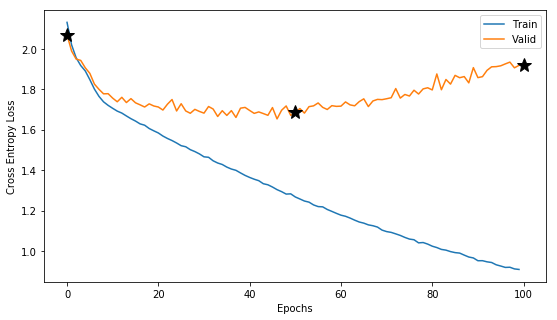

In [82]:
plt.figure(figsize=(9,5))
x = range(len(train_losses))
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(x, train_losses, label='Train')
plt.plot(x, val_losses, label='Valid')
plt.plot([0, 50, 100], [val_losses[0], val_losses[50], val_losses[99]], marker='*', ls='None', markersize=15, c='k')
plt.legend()

os.chdir(home_dir)
plt.savefig('graphics/loss_forward_intervals.png')

In [87]:
# predict midi from init samples
# predict for a certain length
predict_length = 30  
init_index = 42 # 123


generated_track = []
x, y = valid_dataset[init_index]
print(x)
print(y)

x = x.to(device)
x_orig = np.array(x.cpu().detach().numpy() * max(abs(min_interval), max_interval), dtype=int)
generated_track = list(x_orig)
for i in range(predict_length):
    output = model(x)  # predict output from input
    chosen_idx = np.argmax(output.cpu().detach().numpy())
    chosen_interval = interval_values[chosen_idx]
    generated_track.append(chosen_interval)
    x_new = np.array(generated_track[-len(x):])
    x = torch.tensor(x_new / max(abs(min_interval), max_interval), dtype=torch.float32)
    x = x.to(device)
    
print(generated_track)
start_pitch = 74
track = [start_pitch]
for interval in generated_track:
    track.append(track[-1] + interval)
track = np.array(track)
print(track)


# Letting the untrained generate
untrained_model = untrained_model.to(device)
generated_track = []
x, y = valid_dataset[init_index]
print(x)
print(y)

x = x.to(device)
x_orig = np.array(x.cpu().detach().numpy() * max(abs(min_interval), max_interval), dtype=int)
generated_track = list(x_orig)
for i in range(predict_length):
    output = untrained_model(x)  # predict output from input
    chosen_idx = np.argmax(output.cpu().detach().numpy())
    chosen_interval = interval_values[chosen_idx]
    generated_track.append(chosen_interval)
    x_new = np.array(generated_track[-len(x):])
    x = torch.tensor(x_new / max(abs(min_interval), max_interval), dtype=torch.float32)
    x = x.to(device)
    
print(generated_track)
start_pitch = 74
track_untrained = [start_pitch]
for interval in generated_track:
    track_untrained.append(track_untrained[-1] + interval)
track_untrained = np.array(track_untrained)
print(track_untrained)

# Letting the snapshot generate
#model_snapshot = model_snapshot.to(device)
generated_track = []
x, y = valid_dataset[init_index]
print(x)
print(y)

x = x.to(device)
x_orig = np.array(x.cpu().detach().numpy() * max(abs(min_interval), max_interval), dtype=int)
generated_track = list(x_orig)
for i in range(predict_length):
    output = model_snapshot(x)  # predict output from input
    chosen_idx = np.argmax(output.cpu().detach().numpy())
    chosen_interval = interval_values[chosen_idx]
    generated_track.append(chosen_interval)
    x_new = np.array(generated_track[-len(x):])
    x = torch.tensor(x_new / max(abs(min_interval), max_interval), dtype=torch.float32)
    x = x.to(device)
    
print(generated_track)
start_pitch = 74
track_snapshot = [start_pitch]
for interval in generated_track:
    track_snapshot.append(track_snapshot[-1] + interval)
track_snapshot = np.array(track_snapshot)
print(track_untrained)

tensor([-0.1667,  0.0000,  0.1667,  0.0833,  0.1667, -0.2500, -0.1667,  0.0000,
        -0.1667,  0.1667])
tensor(14)
[-2, 0, 2, 1, 2, -3, -2, 0, -2, 2, 2, -2, -2, -1, 0, 2, 1, 2, -2, -1, -2, 2, 0, 0, -2, 2, 1, -1, -2, -2, 2, 0, -2, -2, -1, -2, 2, 1, 2, -2]
[74 72 72 74 75 77 74 72 72 70 72 74 72 70 69 69 71 72 74 72 71 69 71 71
 71 69 71 72 71 69 67 69 69 67 65 64 62 64 65 67 65]
tensor([-0.1667,  0.0000,  0.1667,  0.0833,  0.1667, -0.2500, -0.1667,  0.0000,
        -0.1667,  0.1667])
tensor(14)
[-2, 0, 2, 1, 2, -3, -2, 0, -2, 2, -3, -3, -3, -3, -3, -3, -3, -3, -3, -9, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3]
[ 74  72  72  74  75  77  74  72  72  70  72  69  66  63  60  57  54  51
  48  45  36  33  30  27  24  21  18  15  12   9   6   3   0  -3  -6  -9
 -12 -15 -18 -21 -24]
tensor([-0.1667,  0.0000,  0.1667,  0.0833,  0.1667, -0.2500, -0.1667,  0.0000,
        -0.1667,  0.1667])
tensor(14)
[-2, 0, 2, 1, 2, -3, -2, 0, -2, 2, 2, -2, -2, -1, -2, 2, 

In [89]:
# write numpy to midi track
os.chdir(home_dir)

numpy_notes = midi_utils.prediction_to_numpy(track, 1024)
stop = 50
print(numpy_notes[:stop])
# create midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes, 1, 'Modified')
# make new song with the new track
new_track_dict = {}
new_track_dict['0'] = track_dict['0']
new_track_dict['1'] = new_track
modified_midi_filename = 'results/feedforward_net_track_intervals.mid'
modified_csv_list = midi_utils.track_dict_to_csv(new_track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename)

# UNTRAINED
numpy_notes = midi_utils.prediction_to_numpy(track_untrained, 1024)
stop = 30 # to prevent negative notes
print(numpy_notes[:stop])
# create midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes[:stop], 1, 'Modified')
# make new song with the new track
new_track_dict = {}
new_track_dict['0'] = track_dict['0']
new_track_dict['1'] = new_track
modified_midi_filename_untrained = 'results/feedforward_net_track_intervals_untrained.mid'
modified_csv_list = midi_utils.track_dict_to_csv(new_track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename_untrained)

# SNAPSHOT
numpy_notes = midi_utils.prediction_to_numpy(track_snapshot, 1024)
stop = 50 # to prevent negative notes
#print(numpy_notes[:stop])
# create midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes[:stop], 1, 'Modified')
# make new song with the new track
new_track_dict = {}
new_track_dict['0'] = track_dict['0']
new_track_dict['1'] = new_track
modified_midi_filename_snapshot = 'results/feedforward_net_track_intervals_snapshot.mid'
modified_csv_list = midi_utils.track_dict_to_csv(new_track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename_snapshot)

[[  74 1024]
 [  72 1024]
 [  72 1024]
 [  74 1024]
 [  75 1024]
 [  77 1024]
 [  74 1024]
 [  72 1024]
 [  72 1024]
 [  70 1024]
 [  72 1024]
 [  74 1024]
 [  72 1024]
 [  70 1024]
 [  69 1024]
 [  69 1024]
 [  71 1024]
 [  72 1024]
 [  74 1024]
 [  72 1024]
 [  71 1024]
 [  69 1024]
 [  71 1024]
 [  71 1024]
 [  71 1024]
 [  69 1024]
 [  71 1024]
 [  72 1024]
 [  71 1024]
 [  69 1024]
 [  67 1024]
 [  69 1024]
 [  69 1024]
 [  67 1024]
 [  65 1024]
 [  64 1024]
 [  62 1024]
 [  64 1024]
 [  65 1024]
 [  67 1024]
 [  65 1024]]
[[  74 1024]
 [  72 1024]
 [  72 1024]
 [  74 1024]
 [  75 1024]
 [  77 1024]
 [  74 1024]
 [  72 1024]
 [  72 1024]
 [  70 1024]
 [  72 1024]
 [  69 1024]
 [  66 1024]
 [  63 1024]
 [  60 1024]
 [  57 1024]
 [  54 1024]
 [  51 1024]
 [  48 1024]
 [  45 1024]
 [  36 1024]
 [  33 1024]
 [  30 1024]
 [  27 1024]
 [  24 1024]
 [  21 1024]
 [  18 1024]
 [  15 1024]
 [  12 1024]
 [   9 1024]]


In [90]:
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [60]:
pygame.mixer.music.stop()

In [91]:
# UNTRAINED
pygame.init()
pygame.mixer.music.load(modified_midi_filename_untrained)
pygame.mixer.music.play()

In [92]:
pygame.mixer.music.stop()

In [93]:
# SNAPSHOT
pygame.init()
pygame.mixer.music.load(modified_midi_filename_snapshot)
pygame.mixer.music.play()

In [ ]:
pygame.mixer.music.stop()